<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/VGG19_SEVERE/vgg19_severity_try_with_10epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
80134624/80134624 [==============================] - 3s 0us/step


Epoch 1/10
52/52 [==============================] - 719s 14s/step - loss: 2.3717 - accuracy: 0.4393 - val_loss: 0.9460 - val_accuracy: 0.4318
Epoch 2/10
52/52 [==============================] - 710s 14s/step - loss: 0.7213 - accuracy: 0.6893 - val_loss: 0.7429 - val_accuracy: 0.6420
Epoch 3/10
52/52 [==============================] - 697s 13s/step - loss: 0.6886 - accuracy: 0.6990 - val_loss: 0.8469 - val_accuracy: 0.6534
Epoch 4/10
52/52 [==============================] - 700s 14s/step - loss: 0.6820 - accuracy: 0.6971 - val_loss: 0.6115 - val_accuracy: 0.7102
Epoch 5/10
52/52 [==============================] - 693s 13s/step - loss: 0.6238 - accuracy: 0.7269 - val_loss: 0.6917 - val_accuracy: 0.6648
Epoch 6/10
52/52 [==============================] - 697s 13s/step - loss: 0.6283 - accuracy: 0.7136 - val_loss: 0.7414 - val_accuracy: 0.6250
Epoch 7/10
52/52 [==============================] - 695s 13s/step - loss: 0.6049 - accuracy: 0.7379 - val_loss: 0.7971 - val_accuracy: 0.6477
Epoch 

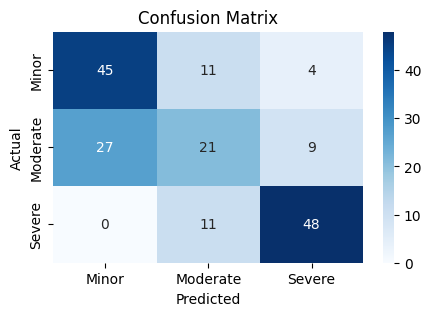

Test loss: 0.7756
Test accuracy: 65.34
Train loss: 0.4260
Train accuracy: 82.81
Recall: 0.64
Precision: 0.63
F1-score: 0.63


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/severity main/train'
val_dir = '/content/drive/MyDrive/severity main/validation'
test_dir = '/content/drive/MyDrive/severity main/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16  # Increase batch size for faster convergence

# Create data generators with additional augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduce rotation range
    width_shift_range=0.1,  # Reduce shift range
    height_shift_range=0.1,  # Reduce shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.1,  # Reduce zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduce dropout rate
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_damage_VGG19_severe_try_10epochs_updated.h5')